[Click here for live site!](https://m-sender.github.io/notupyet)
<center><h1>Music Trends During the Pandemic</h1></center>
<center><b>Sam Broth and Max Sender</b></center>
<center>-------------------------------------------------------</center>

<center>1. Introduction</center>
<center>2. Data: Extraction, Transform and Load</center>
<center>3. Exploratory Data Analysis</center>
<center>4. Visualization</center>
<center>5. What it all means?</center>

<center><h1>1. Introduction</h1></center>

# Goals

# Our Data

# Questions and Hypothesis

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.interpolate import make_interp_spline
from functools import partial
import requests
import json
from lyricsgenius import Genius
import os
from dotenv import load_dotenv
load_dotenv()
import sqlite3
import nltk
import itertools
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob


<center><h1>2. Extraction, Transform and Load </h1></center>

We can do like 2.a, 2.b, etc for tidying and organizing and merging and such with explanations.

In [5]:

tracks_df = pd.read_csv("../datasets/tracks.csv")
artist_df = pd.read_csv("../datasets/artists.csv")
final_df = pd.read_csv("../datasets/Final database.csv")
full_df = pd.read_csv("../datasets/Database to calculate popularity.csv")



# Explain Data sets

# Tidying up our data

In [6]:
#tracks_df.sort_values('popularity', ascending=False)[tracks_df['popularity']>50].head()
#find the most popular tracks
tracks_df.sort_values('popularity', ascending=False).head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
93802,4iJyoBOLtHqaGxP12qzhQI,Peaches (feat. Daniel Caesar & Giveon),100,198082,1,"['Justin Bieber', 'Daniel Caesar', 'Giveon']","['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...",2021-03-19,0.677,0.696,0,-6.181,1,0.1190,0.32100,0.000000,0.4200,0.464,90.030,4
93803,7lPN2DXiMsVn7XUKtOW1CS,drivers license,99,242014,1,['Olivia Rodrigo'],['1McMsnEElThX1knmY4oliG'],2021-01-08,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,4
93804,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,98,132780,0,['Masked Wolf'],['1uU7g3DNSbsu0QjSEqZtEd'],2021-01-06,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.472,149.996,4
92810,5QO79kh1waicV47BqGRL3g,Save Your Tears,97,215627,1,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,4
92811,6tDDoYIxWvMLTdKpjFkc1B,telepatía,97,160191,0,['Kali Uchis'],['1U1el3k54VvEUzo3ybLPlM'],2020-12-04,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,0.2030,0.553,83.970,4
93805,7MAibcTli4IisCtbHKrGMh,Leave The Door Open,96,242096,0,"['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']","['0du5cEVh5yTK9QJze8zA0C', '3jK9MiCrA42lLAdMGU...",2021-03-05,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,0.0927,0.719,148.088,4
92813,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,96,200040,0,['The Weeknd'],['1Xyo4u8uXC1ZmMpatF05PJ'],2020-03-20,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4
92814,6f3Slt0GbA2bPZlz0aIFXN,The Business,95,164000,0,['Tiësto'],['2o5jDhtHVPhrJdv3cEQ99Z'],2020-09-16,0.798,0.620,8,-7.079,0,0.2320,0.41400,0.019200,0.1120,0.235,120.031,4
92816,3FAJ6O0NOHQV8Mc5Ri6ENp,Heartbreak Anniversary,94,198371,0,['Giveon'],['4fxd5Ee7UefO4CUXgwJ7IP'],2020-03-27,0.449,0.465,0,-8.964,1,0.0791,0.52400,0.000001,0.3030,0.543,89.087,3
92819,1xK1Gg9SxG8fy2Ya373oqb,Bandido,94,232853,0,"['Myke Towers', 'Juhn']","['7iK8PXO48WeuP03g8YR51W', '2LmcxBak1alK1bf7d1...",2020-12-10,0.713,0.617,8,-4.637,1,0.0887,0.12200,0.000000,0.0962,0.682,168.021,4


In [7]:
mental_health_df = pd.read_csv("../datasets/mentalHealth_searchTrend.csv")


In [8]:
mental_health_df

,Category: All categories
Week,mental health: (United States)
2019-01-06,67
2019-01-13,65
2019-01-20,64
2019-01-27,65
...,...
2021-09-19,80
2021-09-26,84
2021-10-03,83
2021-10-10,94


In [9]:
full_df['date'] = pd.to_datetime(full_df['date'],dayfirst=True)
full_df


,Unnamed: 0,country,date,position,uri,track,title,artist
0,0,Global,2020-11-05,1.0,https://open.spotify.com/track/47EiUVwUp4C9fGc...,"Dakiti , Bad Bunny, Jhay Cortez",Dakiti,"Bad Bunny, Jhay Cortez"
1,1,Global,2020-11-05,2.0,https://open.spotify.com/track/35mvY5S1H3J2QZy...,"positions , Ariana Grande",positions,Ariana Grande
2,2,Global,2020-11-05,3.0,https://open.spotify.com/track/3tjFYV6RSFtuktY...,"Mood , 24kGoldn",Mood,24kGoldn
3,3,Global,2020-11-05,4.0,https://open.spotify.com/track/7hxHWCCAIIxFLCz...,"Lemonade , Internet Money",Lemonade,Internet Money
4,4,Global,2020-11-05,5.0,https://open.spotify.com/track/4y4spB9m0Q6026K...,"Lonely , Justin Bieber",Lonely,Justin Bieber
...,...,...,...,...,...,...,...,...
9806996,9806996,Taiwan,2017-01-01,197.0,https://open.spotify.com/track/3zHq9ouUJQFQRf3...,"Love Me Like You Do - From ""Fifty Shades Of G...","Love Me Like You Do - From ""Fifty Shades Of G...",Ellie Goulding
9806997,9806997,Taiwan,2017-01-01,198.0,https://open.spotify.com/track/3CRDbSIZ4r5MsZ0...,"Stressed Out , Twenty One Pilots",Stressed Out,Twenty One Pilots
9806998,9806998,Taiwan,2017-01-01,199.0,https://open.spotify.com/track/2mEvsc8k8iwR099...,"The End - From ""La La Land"" Soundtrack , Just...","The End - From ""La La Land"" Soundtrack",Justin Hurwitz
9806999,9806999,Taiwan,2017-01-01,200.0,https://open.spotify.com/track/0L7loeTIg6akW84...,"Light It Up - Remix , Major Lazer",Light It Up - Remix,Major Lazer


In [10]:
full_df.iloc[305933].uri
full_df['id'] = [x.split('/')[-1] if type(x)==str else float('nan') for x in full_df.uri.values]

In [11]:
f = partial(pd.to_datetime,yearfirst=True)
working_df = full_df[(full_df['date']>=f('01/01/2020')) & (full_df['date']<=f('06/30/2020'))].sort_values('date',ascending=False)

In [12]:
working_df

,Unnamed: 0,country,date,position,uri,track,title,artist,id
25600,25600,Global,2020-06-30,1.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4
8151541,8151541,Poland,2020-06-30,142.0,https://open.spotify.com/track/68zNuCEl9UHTbcB...,"Someone , Jubël",Someone,Jubël,68zNuCEl9UHTbcBltW2uDv
8151539,8151539,Poland,2020-06-30,140.0,https://open.spotify.com/track/35UvOH0tRlSCdtW...,"Najnowszy Klip , Dawid Podsiadło",Najnowszy Klip,Dawid Podsiadło,35UvOH0tRlSCdtWtaXuiWh
8151538,8151538,Poland,2020-06-30,139.0,https://open.spotify.com/track/7qEHsqek33rTcFN...,"Someone You Loved , Lewis Capaldi",Someone You Loved,Lewis Capaldi,7qEHsqek33rTcFNT9PFqLf
8151537,8151537,Poland,2020-06-30,138.0,https://open.spotify.com/track/66W1rVTnEv86dIk...,"Secrets , Regard, RAYE",Secrets,"Regard, RAYE",66W1rVTnEv86dIkFhoiElg
...,...,...,...,...,...,...,...,...,...
3984732,3984732,Denmark,2020-01-01,133.0,https://open.spotify.com/track/6TfeXwJihJRuBW3...,"DANCE , CLMD, Tungevaag",DANCE,"CLMD, Tungevaag",6TfeXwJihJRuBW3mFpib6J
3984731,3984731,Denmark,2020-01-01,132.0,https://open.spotify.com/track/4Jh3p0TydgTJZ44...,"STANDARD , I$WAAL",STANDARD,I$WAAL,4Jh3p0TydgTJZ444pPhVvd
3984730,3984730,Denmark,2020-01-01,131.0,https://open.spotify.com/track/6N1EjQjnvhOjFrF...,"Summer Of '69 , Bryan Adams",Summer Of '69,Bryan Adams,6N1EjQjnvhOjFrF6oUmGPa
3984729,3984729,Denmark,2020-01-01,130.0,https://open.spotify.com/track/2geMSoH29SfXAZV...,"Boing! , Nik & Jay",Boing!,Nik & Jay,2geMSoH29SfXAZVgPR8avw


In [13]:
tracks_df[(tracks_df['name']=='Tongue Tied') & (tracks_df['artists']=="['Grouplove']")]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
84077,0GO8y8jQk1PkHzS31d699N,Tongue Tied,83,218013,0,['Grouplove'],['3kVUvbeRdcrqQ3oHk5hPdx'],2011-09-02,0.56,0.936,3,-5.835,1,0.0439,0.00847,0.0,0.161,0.371,112.96,4
462056,5urJXg073FQhGTYsmOc4dB,Tongue Tied,49,218013,0,['Grouplove'],['3kVUvbeRdcrqQ3oHk5hPdx'],2011-09-13,0.56,0.936,3,-5.835,1,0.0439,0.00847,0.0,0.161,0.371,112.96,4
492450,678jXJOHDRZJT8IBzwgQFb,Tongue Tied,45,218013,0,['Grouplove'],['3kVUvbeRdcrqQ3oHk5hPdx'],2011-09-02,0.56,0.936,3,-5.835,1,0.0439,0.00847,0.0,0.161,0.371,112.96,4


In [14]:
holder_df = working_df.merge(tracks_df,on='id',how='inner')
holder_df.head()

,Unnamed: 0,country,date,position,uri,track,title,artist,id,name,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,25600,Global,2020-06-30,1.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),...,11,-7.956,1,0.164,0.247,0.0,0.101,0.497,89.977,4
1,1987055,Brazil,2020-06-30,56.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),...,11,-7.956,1,0.164,0.247,0.0,0.101,0.497,89.977,4
2,8151422,Poland,2020-06-30,23.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),...,11,-7.956,1,0.164,0.247,0.0,0.101,0.497,89.977,4
3,8431600,Portugal,2020-06-30,1.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),...,11,-7.956,1,0.164,0.247,0.0,0.101,0.497,89.977,4
4,1706800,Belgium,2020-06-30,1.0,https://open.spotify.com/track/7ytR5pFWmSjzHJI...,"ROCKSTAR , DaBa,",ROCKSTAR,"DaBa,",7ytR5pFWmSjzHJIeQkgog4,ROCKSTAR (feat. Roddy Ricch),...,11,-7.956,1,0.164,0.247,0.0,0.101,0.497,89.977,4


<center><h1>3. Exploratory Data Analysis</h1></center>


We break down our data analysis into 3 parts:
* (3.1) Analysis and Representation of Provided Metrics
* (3.2) NLP sentiment analysis of the lyrics per genre
* (3.3) Meshing the data together and pursuing further analysis

<center><h3>3.1: Analysis and Representation of Provided Metrics</h3></center>

In [15]:
#Code for plotting graphs and metrics
def createMetricComparison(metricName,dataFrame): #change to zscore // streams per week (look)
    fig, ax = plt.subplots(1,2,figsize=(25,12), sharey=True, sharex=False)
    title = metricName[0].upper()+ metricName[1:] + ' Before and After Pandemic Begins'
    fig.suptitle(title,fontsize=16)

    

    #full_lyr[full_lyr['country']== 'USA'].plot.scatter(x='date',y='danceability', c='liveness',ax=ax)
    #group by dates, get scores for each in terms of danceability and apply weight, then sum, them plot
    #convert zscore = 
    
    std_df = dataFrame[(dataFrame['date']<=f('03/10/2020')) & (dataFrame['date']>f('03/10/2020'))]
    dataFrame[metricName] = (dataFrame[metricName] - dataFrame[metricName].mean())/dataFrame[metricName].std()
    pre_pandemic = dataFrame[(dataFrame['date']<=f('03/10/2020'))] #  & (holder_df['date'].dt.day % 7 == 0)
    pandemic = dataFrame[(dataFrame['date']>f('03/10/2020'))] # & (holder_df['date'].dt.day % 7 == 0)
    pre_pandemic = pre_pandemic[pre_pandemic['country']=='USA']
    pandemic = pandemic[pandemic['country']=='USA']
  
    
    
    pp_groupby = pre_pandemic.groupby('date')[metricName].mean() 
    dp_groupby = pandemic.groupby('date')[metricName].mean() 
    #get zscore
    '''pp_groupby_z = (pp_groupby - pp_groupby.mean())/pp_groupby.std()
    dp_groupby_z = (dp_groupby - dp_groupby.mean())/dp_groupby.std()'''
    std_pre = pp_groupby.std()
    pp_groupby.plot(ax=ax[0],title='Before Pandemic',ylabel=metricName, xlabel='Date')
    dp_groupby.plot(ax=ax[1],title='After Pandemic Begins', xlabel='Date',ylabel=metricName)
    #plt.axhline(y=pp_groupby.mean(), color='r', linestyle='-')
    ax[0].hlines(y=pp_groupby.mean(), xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='r')
    ax[0].hlines(y=pp_groupby.mean()+std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='y',linestyle='--')
    ax[0].hlines(y=pp_groupby.mean()-std_pre, xmin="01-01-2020", xmax="03-10-2020", linewidth=2, color='y',linestyle='--')
    
    #plt.axhline( y=dp_groupby.mean(), color='r', linestyle='-')
    ax[1].hlines(y=pp_groupby.mean()+std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='y',linestyle='--')
    ax[1].hlines(y=pp_groupby.mean()-std_pre, xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='y',linestyle='--')
    
    ax[1].hlines(y=dp_groupby.mean(), xmin="03-11-2020", xmax="06-30-2020", linewidth=2, color='r')

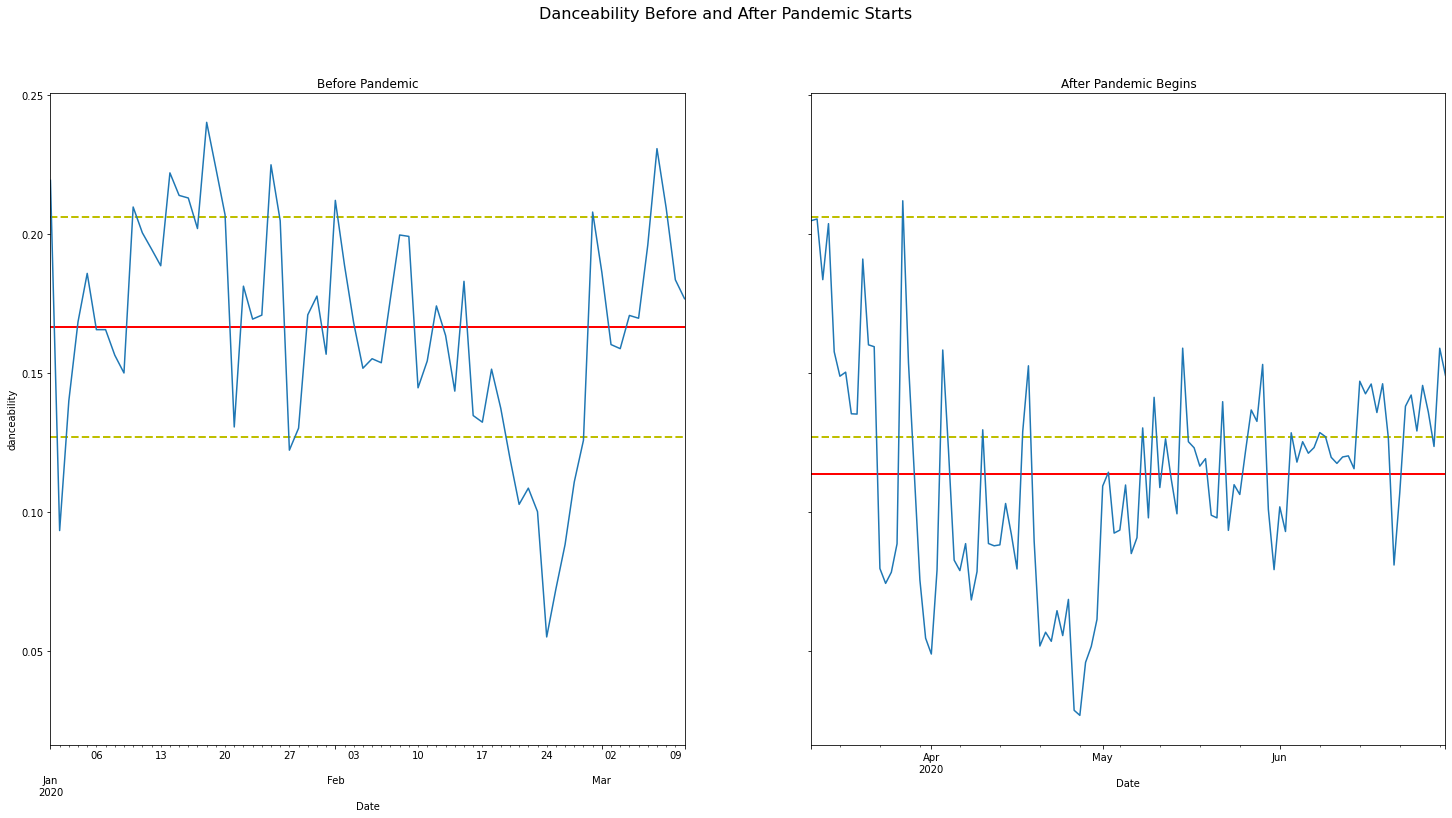

In [16]:
createMetricComparison('danceability',holder_df)

In [17]:
metric_list = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','key','mode']
for metric in metric_list:
    #createMetricComparison(metric,holder_df)
    pass

<center><h3>3.2: NLP sentiment analysis of the lyrics per genre</h3></center>

Using genius API we obtained lyrics and stored in sqlite file for use, (see lyricgrabber)

In [18]:
conn = sqlite3.connect('../datasets/lyrics.db')

lyric_df = pd.read_sql_query("SELECT * FROM lyrics", conn)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSend\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
lyric_df.rename(columns={'song':'title'},inplace=True)
lyric_df.head()

,title,artist,lyric,uri,sentiment,polarity,subjectivity,vader,vader_pos,vader_neg,vader_neut
0,positions,[' Ariana Grande '],​positions Lyrics Heaven sent you to me Im jus...,https://open.spotify.com/track/35mvY5S1H3J2QZy...,1,0.136111,0.575794,0.9770,0.152,0.087,0.761
1,Lemonade,[' Internet Money '],"Lemonade Lyrics Xanny bars, suicide door, bran...",https://open.spotify.com/track/7hxHWCCAIIxFLCz...,-1,0.013710,0.546575,-0.9821,0.118,0.157,0.725
2,34+35,[' Ariana Grande '],34+35 Lyrics Hmm You might think Im crazy The ...,https://open.spotify.com/track/6Im9k8u9iIzKMrm...,1,0.070635,0.604190,0.9989,0.304,0.102,0.595
3,Dakiti,"[' Bad Bunny', ' Jhay Cortez ']","DÁKITI Lyrics Baby, ya yo me enteré, se nota c...",https://open.spotify.com/track/47EiUVwUp4C9fGc...,-1,0.000000,0.000000,-0.9681,0.024,0.085,0.892
4,Mood,[' 24kGoldn '],"Mood Lyrics Oh-oh-oh Yeah, yeah, yeah, yeah Ye...",https://open.spotify.com/track/3tjFYV6RSFtuktY...,1,0.130655,0.484787,0.9980,0.250,0.084,0.666


In [20]:
pre_pandemic_lyr = working_df[(working_df['date']<=f('03/10/2020'))]# & (holder_df['date'].dt.day % 7 == 0)]
pandemic_lyr = working_df[(working_df['date']>f('03/10/2020'))]# & (holder_df['date'].dt.day % 7 == 0)]
full_lyr = pd.merge(pre_pandemic_lyr,pandemic_lyr,how='outer')
full_lyr = pd.merge(full_lyr,lyric_df,how='inner',on='uri')


In [21]:
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

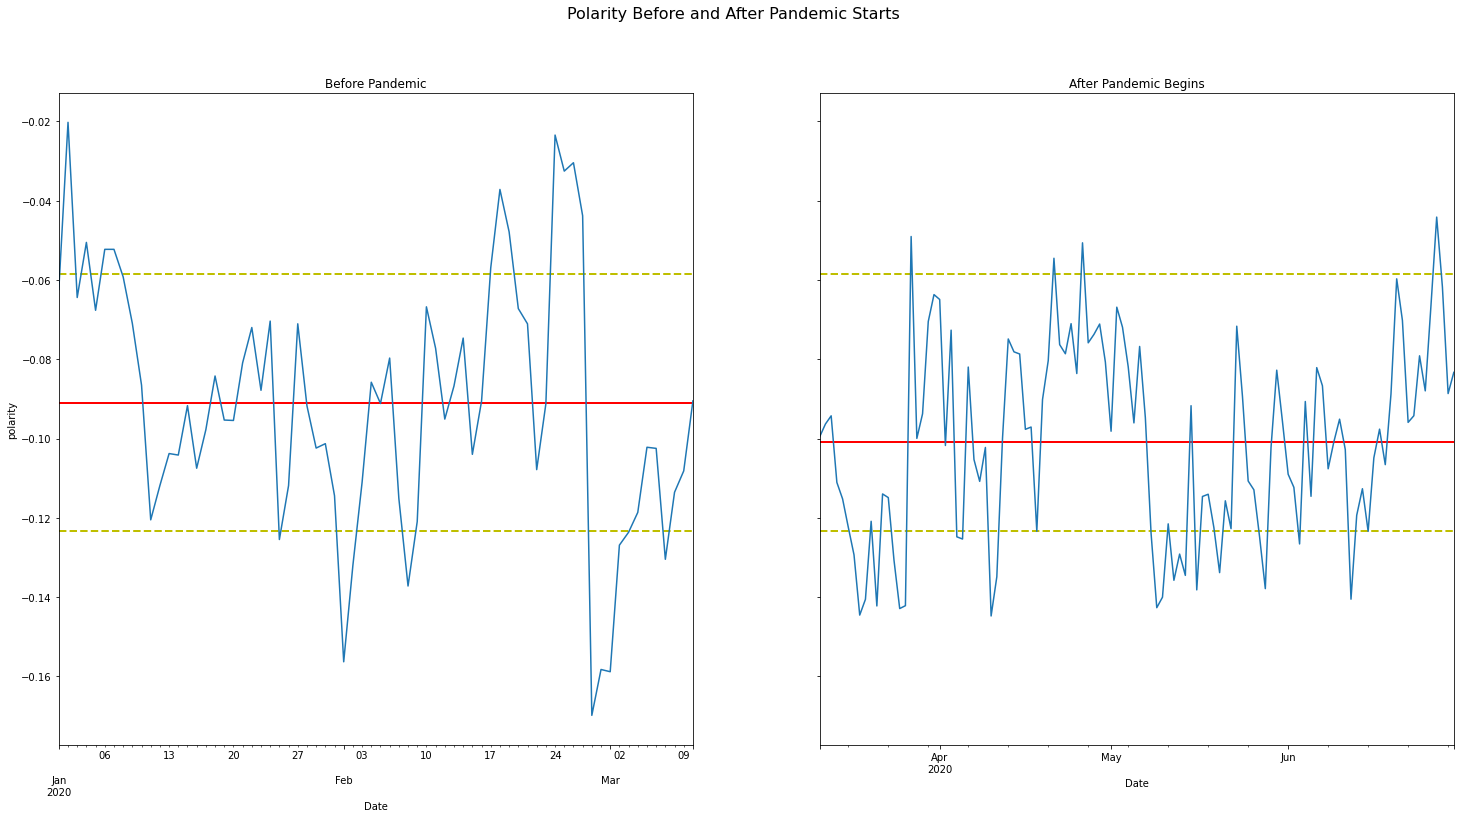

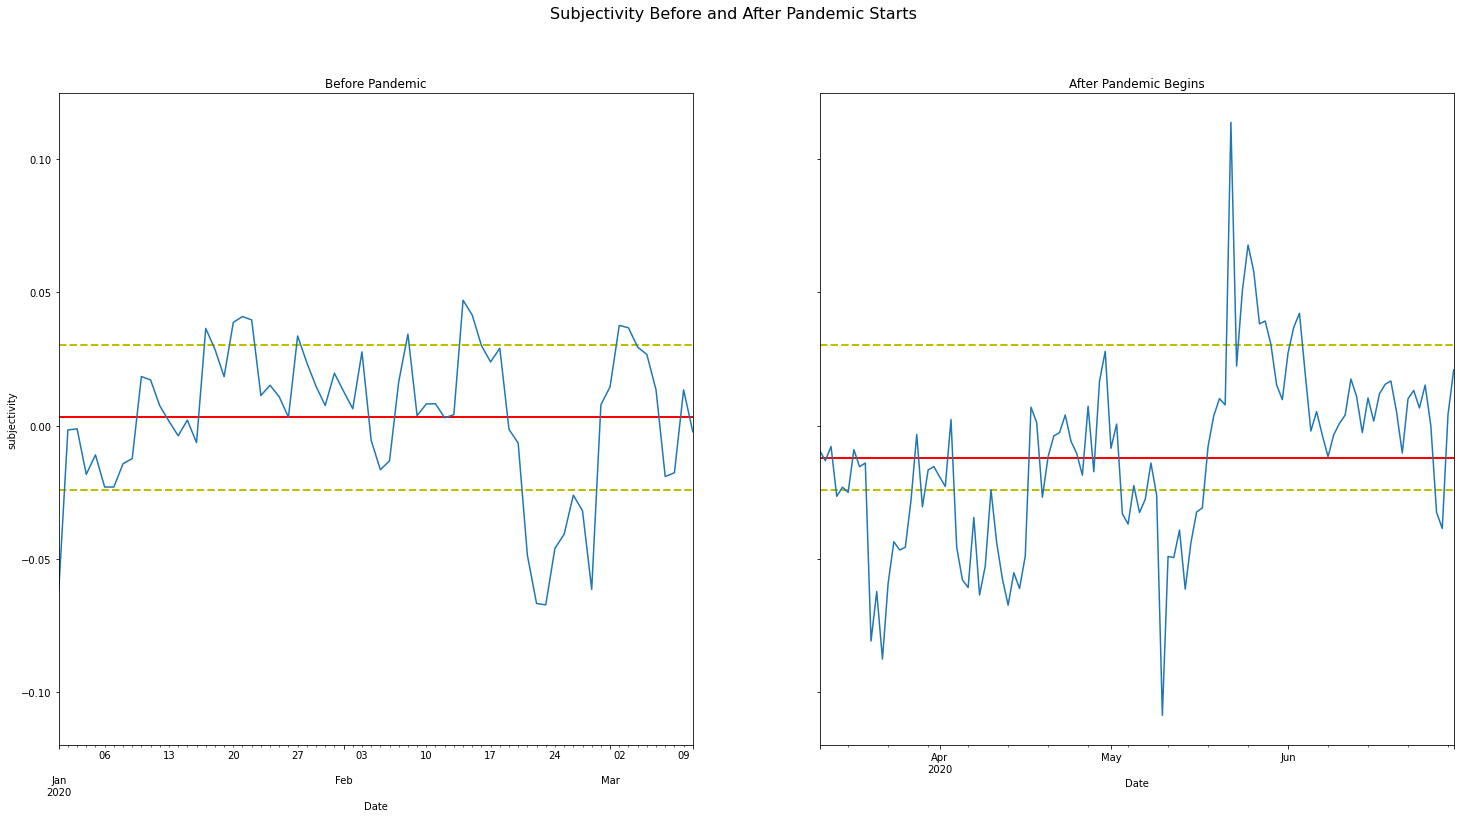

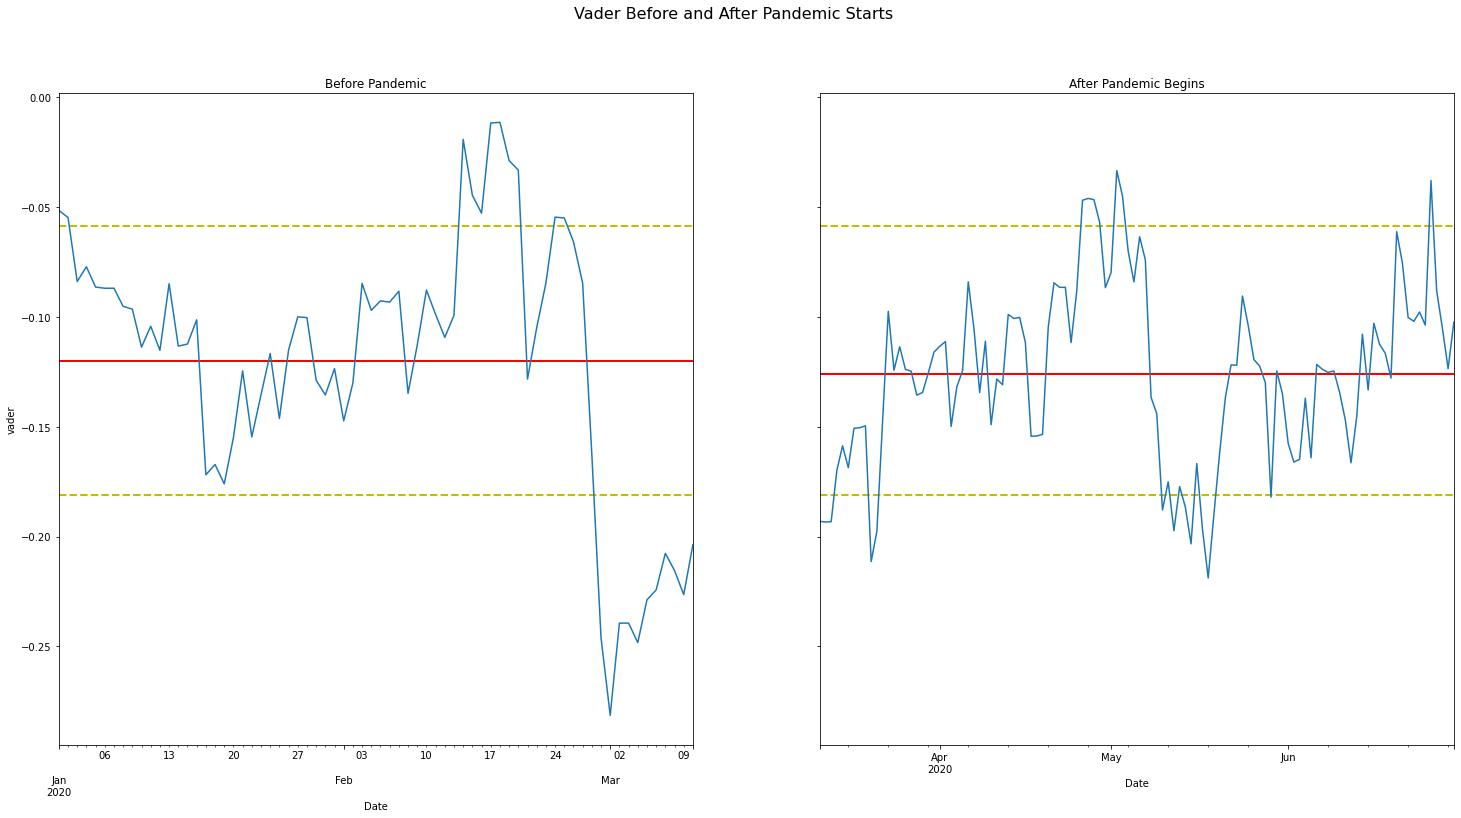

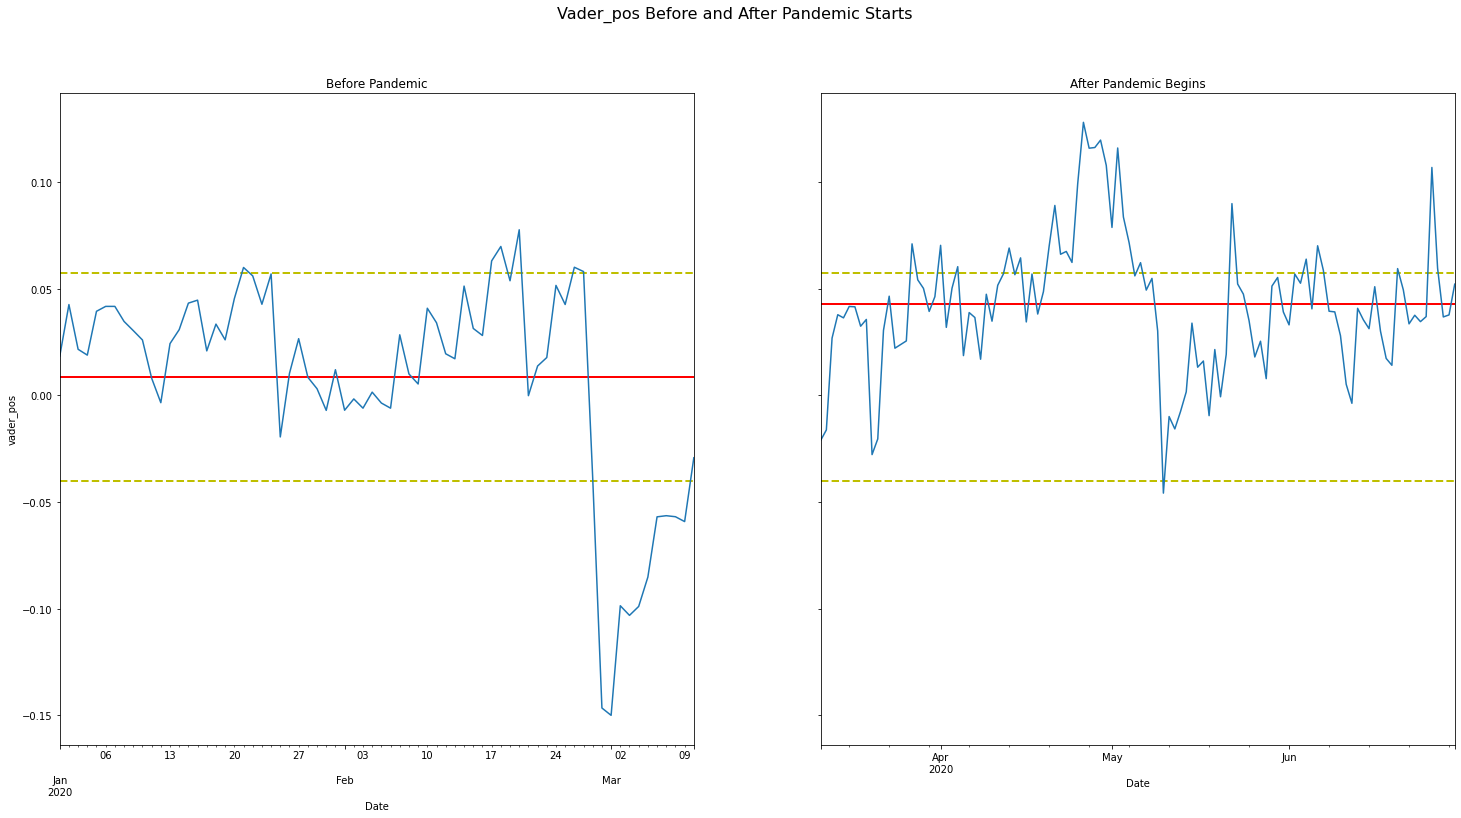

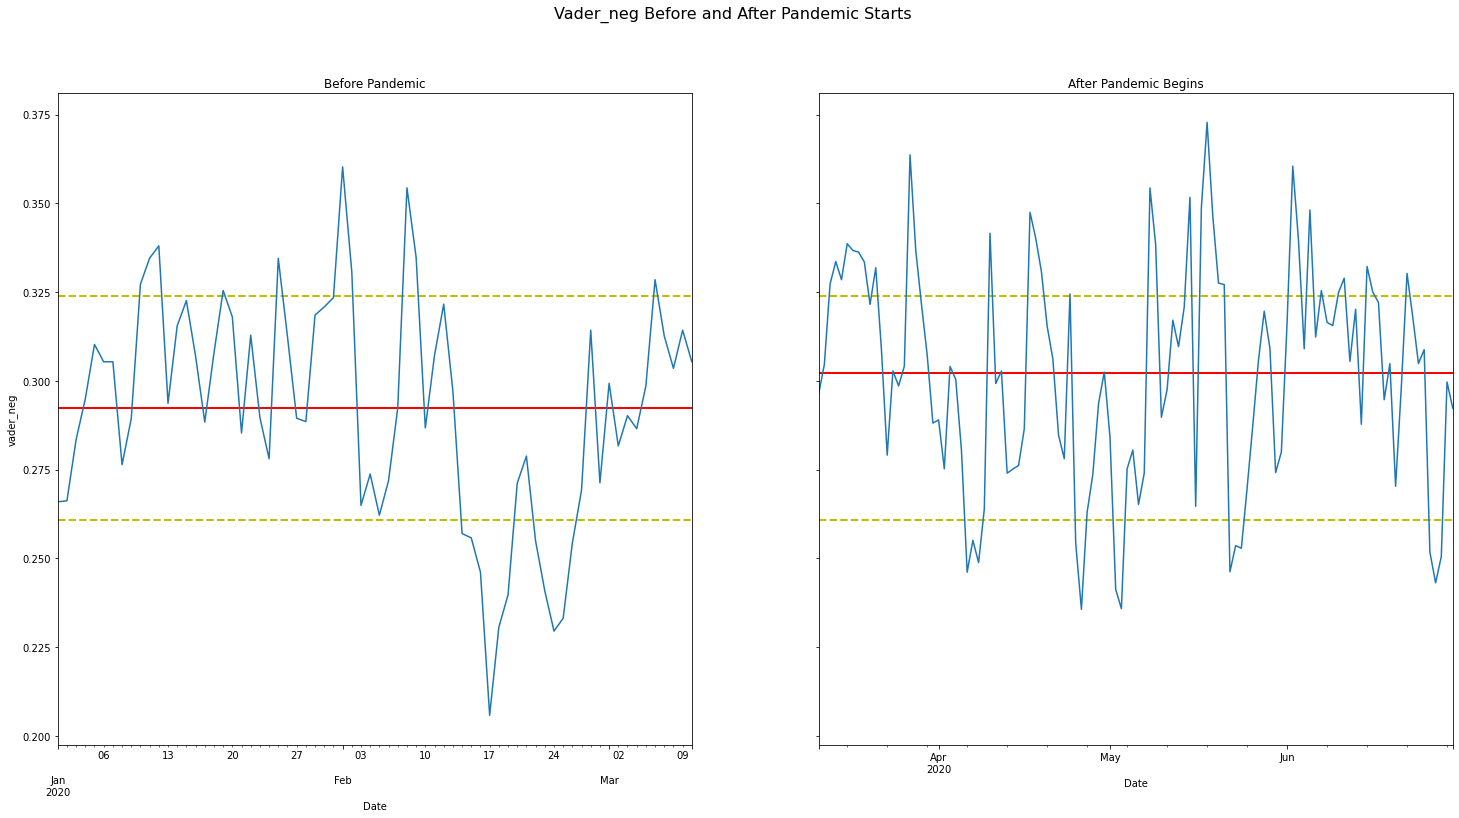

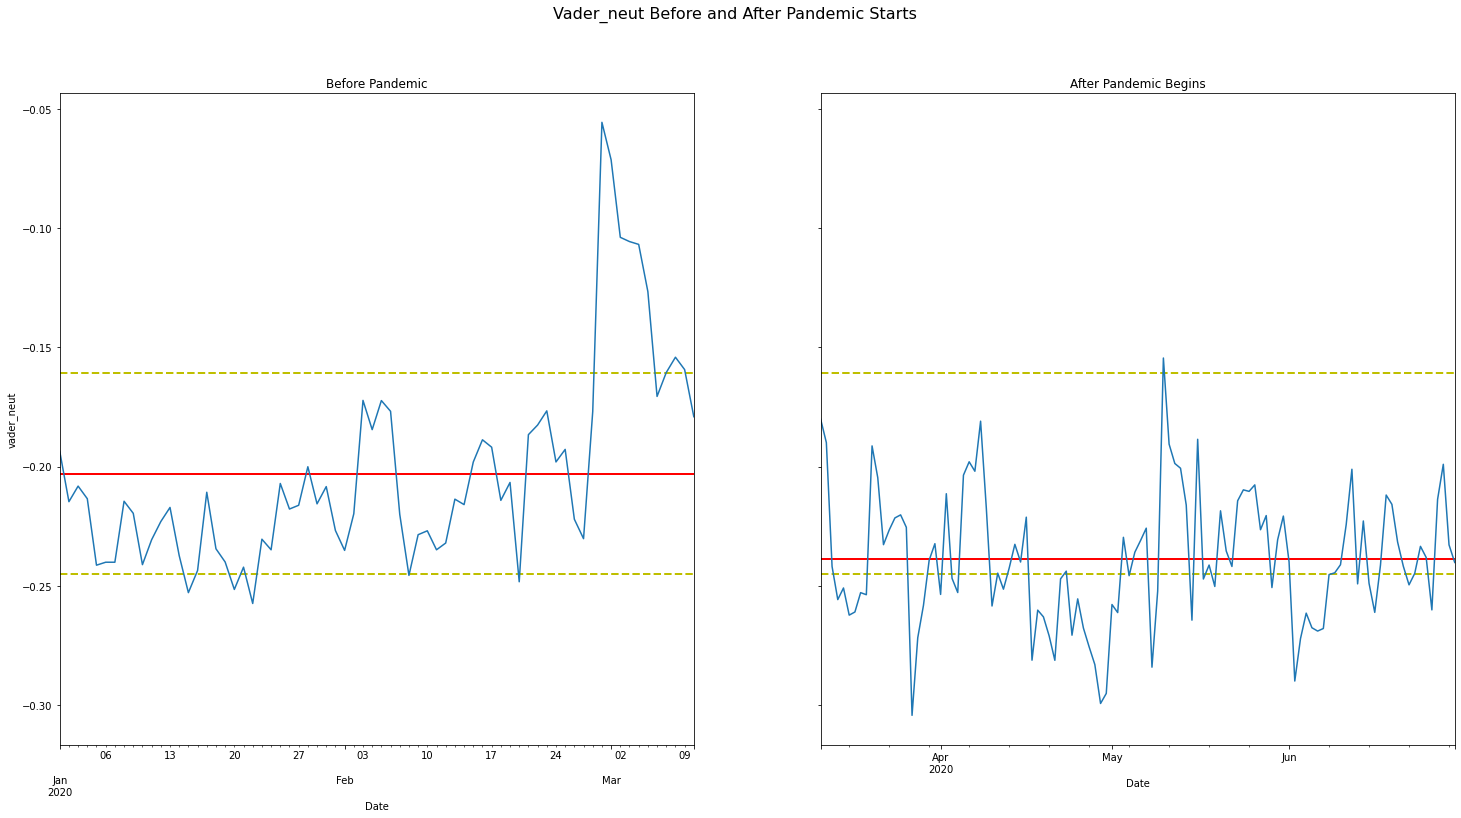

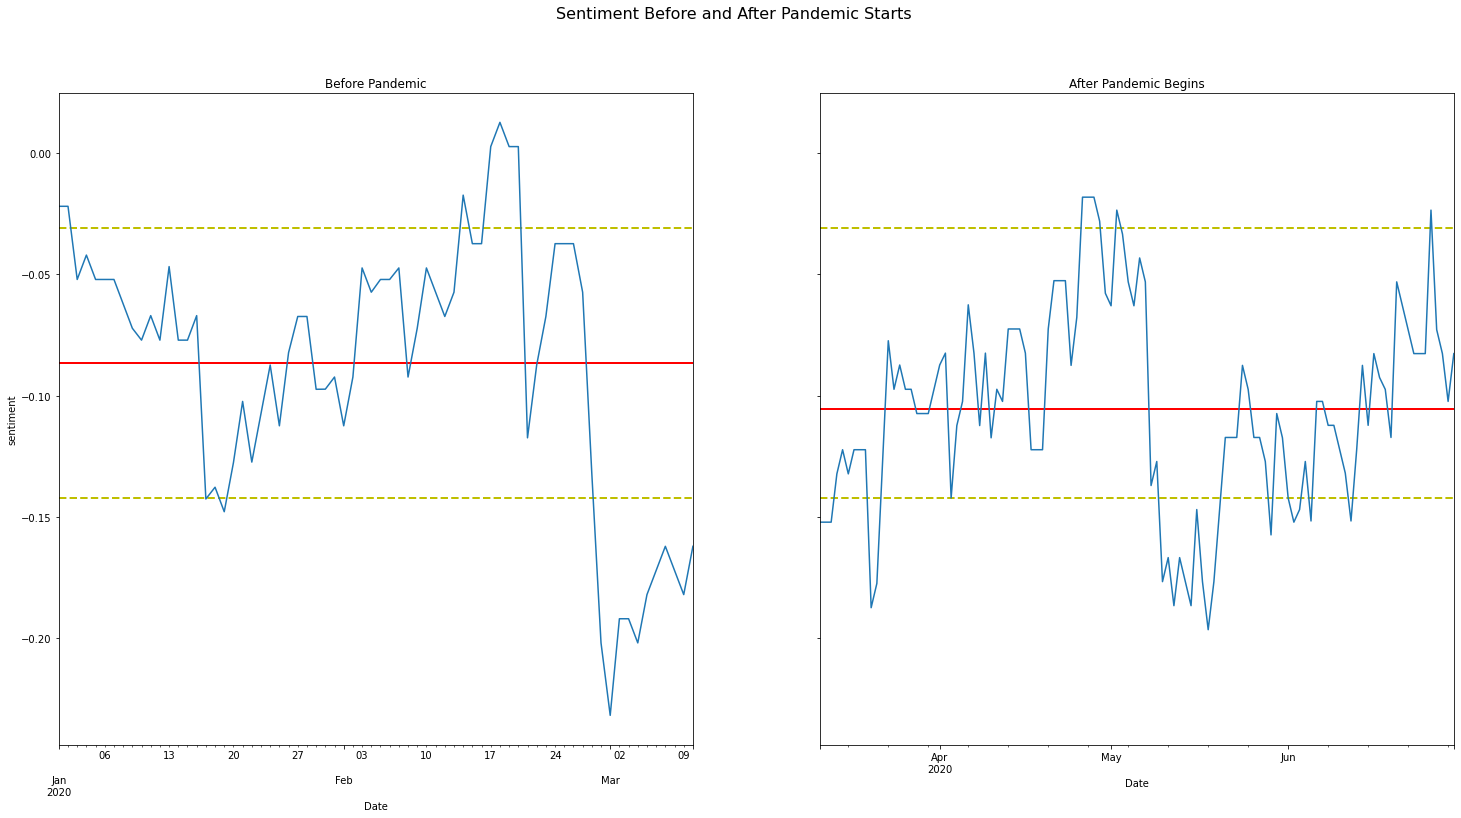

In [28]:
for i in ['polarity','subjectivity','vader','vader_pos','vader_neg','vader_neut','sentiment']:
    createMetricComparison(i,full_lyr)

Looking at these charts, interesting to see that neutrality decreased but the songs become more polarized as negative and postive both increased.

<center><h3>3.3: Meshing the data together and pursuing further analysis</h3></center>

<center><h1>4. Visualization</h1></center>

<center><h1>5. What it all means?</h1></center>

Conclusion